# Ly thuyet

In [ ]:
'''
    1.A
    2.A
    3.C
    4.B
    5.C, D

'''

'\n    1.A\n    2.B\n    3.C\n    4.B\n    5.C, D\n\n'

# Thuc Hanh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Hien
!ls

/content/drive/MyDrive/Hien
5.CNN_VuXuanHien	       mobilev3_best.pth       test
6_VuXuanHien_Homework.ipynb    resnet50_best.pth       TestCNN.ipynb
distill_best.pth	       ResNet50.pt	       test_resnet50_best.pth
dog-vs-cat-classification.zip  resnet_tuning_best.pth  train
mobilenet_best.pth	       sample_submission.csv


In [ ]:
import os
import glob
import time
from PIL import Image 
import tqdm

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

import torchvision
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import random
import torchvision.transforms as T

from sklearn.model_selection import train_test_split

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_images = glob.glob('train/train'+"/**/**.jpg")
test_images = glob.glob('test/test'+'/**.jpg')

class_to_int = {"dogs" : 0, "cats" : 1}
int_to_class = {0 : "dogs", 1 : "cats"}

In [ ]:
# Transformation function

def get_train_transform():
  return T.Compose([
                    T.ToTensor(),
                    T.Resize((256,256)),
                    T.CenterCrop((224,224)),
                    T.RandomRotation(20),
                    T.RandomHorizontalFlip(0.5),
                    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
  ])


def get_val_transform():
  return T.Compose([
                    T.ToTensor(),
                    T.Resize((224,224)),
                    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
  ])

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, imgs, class_to_int, mode='train', transforms=None):
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
    
    def __getitem__(self, index):
        image_name = self.imgs[index]
        if self.mode == "train" or self.mode == "val":
          img = Image.open(image_name)
          label = self.class_to_int[image_name.split("/")[-2]]
          label = torch.tensor(label, dtype = torch.float32)
          img = self.transforms(img)
          return img, label
        elif self.mode == "test":
          img = Image.open(image_name)
          img = self.transforms(img)
          return img, image_name

    def __len__(self):
        return len(self.imgs)


In [ ]:
train_imgs, val_imgs = train_test_split(train_images, test_size = 0.2)

train_dataset = CatDogDataset(train_imgs, class_to_int, mode = "train",
                              transforms = get_train_transform())
val_dataset = CatDogDataset(val_imgs, class_to_int, mode = "val", 
                            transforms = get_val_transform())
test_dataset = CatDogDataset(test_images, class_to_int, mode = "test", 
                             transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 2,
    batch_size = 32,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 2,
    batch_size = 32,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 2,
    batch_size = 32,
    shuffle = False
)

In [ ]:
def accuracy(preds, trues):
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    acc = np.sum(acc) / len(preds)
    return (acc * 100)

In [ ]:
def train(train_data_loader, model, optimizer):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    model.train()
    
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1))

        optimizer.zero_grad()

        preds = model(images)

        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)

        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        _loss.backward()
        optimizer.step()
    
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

In [ ]:
def val(val_data_loader, model, best_val_acc, model_name):

    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    # model.to(device)
    model.eval()

    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),model_name+"_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc


In [ ]:
from torchvision.models import resnet50
model = resnet50(pretrained = True)

for param in model.parameters():
    param.requires_grad = False
# Modifying Head - classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Warm up

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Learning Rate Scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 1

In [ ]:
best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train(train_data_loader, model, optimizer)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val(val_data_loader, model, best_val_acc, "test_resnet50")
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))


Training
Epoch 1
Loss : 0.1253
Acc : 95.64
Time : 2779.0408

Validating
Epoch 1
Loss : 0.0536
Acc : 98.0295
Time : 643.3754


# Fine tuning ResNet

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Learning Rate Scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 5

best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train(train_data_loader, model, optimizer)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val(val_data_loader, model, best_val_acc, "resnet_tuning")
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))


Training
Epoch 1
Loss : 0.2506
Acc : 89.5
Time : 194.7688

Validating
Epoch 1
Loss : 0.251
Acc : 90.7842
Time : 29.9749

Training
Epoch 2
Loss : 0.1825
Acc : 92.27
Time : 194.4298

Validating
Epoch 2
Loss : 0.1485
Acc : 93.8296
Time : 30.0727

Training
Epoch 3
Loss : 0.1498
Acc : 93.835
Time : 193.4355

Validating
Epoch 3
Loss : 0.1581
Acc : 93.551
Time : 30.2628

Training
Epoch 4
Loss : 0.1363
Acc : 94.45
Time : 196.8146

Validating
Epoch 4
Loss : 0.1792
Acc : 91.9586
Time : 30.088

Training
Epoch 5
Loss : 0.1269
Acc : 94.61
Time : 195.678

Validating
Epoch 5
Loss : 0.0997
Acc : 96.039
Time : 30.0222


# MobileNetv3

In [ ]:
mobile = torchvision.models.mobilenet_v3_small(pretrained=True)

for param in mobile.parameters():
    param.requires_grad = False
mobile.classifier._modules['3']  = nn.Sequential(
    nn.Linear(1024, 1, bias = True),
    nn.Sigmoid()
)
print(mobile)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(mobile.parameters(), lr = 0.001)

# Learning Rate Scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
mobile.to(device)

# No of epochs 
epochs = 1

best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train(train_data_loader, mobile, optimizer)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val(val_data_loader, mobile, best_val_acc, "mobilev3")
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))


Training
Epoch 1
Loss : 0.2121
Acc : 92.075
Time : 165.2808

Validating
Epoch 1
Loss : 0.1357
Acc : 94.4467
Time : 28.4359


# Knowledge Distillation

In [ ]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return (num_correct/num_samples).item()

In [ ]:
def train_step(
    teacher,
    student,
    optimizer,
    student_loss_fn,
    divergence_loss_fn,
    temp,
    alpha,
    epoch,
    device
):
    losses = []
    # pbar = tqdm(train_data_loader, total=len(train_data_loader))
    for data, targets in train_data_loader:
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)
        targets = targets.reshape((targets.shape[0], 1))
        # forward
        with torch.no_grad():
            teacher_preds = teacher(data)

        student_preds = student(data)
        student_loss = student_loss_fn(student_preds, targets)
        
        ditillation_loss = divergence_loss_fn(
            F.softmax(student_preds / temp, dim=1),
            F.softmax(teacher_preds / temp, dim=1)
        )
        loss = alpha * student_loss + (1 - alpha) * ditillation_loss
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    
    avg_loss = sum(losses) / len(losses)
    return avg_loss

In [ ]:
import torch.nn.functional as F
temp=7
alpha=0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_loss_fn = nn.BCELoss()
divergence_loss_fn = nn.KLDivLoss(reduction="batchmean")
optimizer = torch.optim.Adam(mobile.parameters(), lr=1e-4)
epoch = 5
model = model.to(device)
mobile = mobile.to(device)

model.eval()
mobile.train()
best_val_acc = 0
val_logs = {"loss" : [], "accuracy" : [], "time" : []}
for epoch in range(epochs):
      loss = train_step(
            model,
            mobile,
            optimizer,
            student_loss_fn,
            divergence_loss_fn,
            temp,
            alpha,
            epoch,
            device
        )
      loss, acc, _time, best_val_acc = val(val_data_loader, mobile, best_val_acc, "distill")
    
      #Print Epoch Details
      print("\nValidating")
      print("Epoch {}".format(epoch+1))
      print("Loss : {}".format(round(loss, 4)))
      print("Acc : {}".format(round(acc, 4)))
      print("Time : {}".format(round(_time, 4)))



Validating
Epoch 1
Loss : 0.1341
Acc : 94.5263
Time : 28.3669


# MixUp


 MixUp Visualize

In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 4.3 MB/s 


In [ ]:
import torch
from timm.data.mixup import Mixup
from timm.data.dataset import ImageDataset
from timm.data.loader import create_loader
import random
import numpy as np

In [ ]:
def get_dataset_and_loader(mixup_args):
    mixup_fn = Mixup(**mixup_args)
    dataset = ImageDataset('train/train')
    loader = create_loader(dataset, 
                           input_size=(3,224,224), 
                           batch_size=4, 
                           is_training=True, 
                           use_prefetcher=False)
    return mixup_fn, dataset, loader

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
mixup_args = {
    'mixup_alpha': 1,
    'cutmix_alpha': 0.,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.,
    'mode': 'batch',
    'label_smoothing': 0,
    'num_classes': 2}


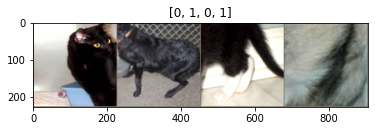

In [ ]:
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

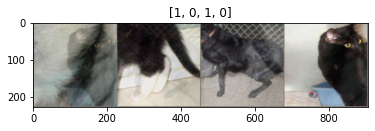

In [ ]:
inputs, classes = mixup_fn(inputs, classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes.argmax(1)])

CutMix Visualize

In [ ]:
mixup_args = {
    'mixup_alpha': 0,
    'cutmix_alpha': 1.,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.,
    'mode': 'batch',
    'label_smoothing': 0,
    'num_classes': 2}

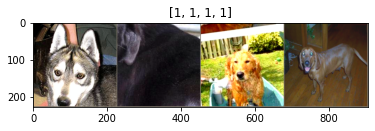

In [ ]:
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

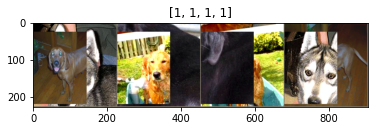

In [ ]:
inputs, classes = mixup_fn(inputs, classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes.argmax(1)])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from matplotlib import transforms
class MixDataset(Dataset):
    def __init__(self, imgs, class_to_int, mode='train', transforms=None):
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        # self.data = np.vstack(self.imgs).reshape(-1, 3, 32, 32)
        # self.data = self.imgs.transpose((0, 2, 3, 1))
        
    def __getitem__(self, index):
        image_name = self.imgs[index]
        if self.mode == 'train':
          img = Image.open(image_name)

          label = self.class_to_int[image_name.split("/")[-2]]

          image = self.transforms(img)
          label_mix = torch.zeros(2)
          label_mix[label] = 1

          if index>0 and index%5==0:
            # Choose another image/label randomly
            mixup_idx = random.randint(0, len(self.imgs)-1)
            mixup_label = torch.zeros(2)
            image_name = self.imgs[mixup_idx]
            img = Image.open(image_name)
            label = self.class_to_int[image_name.split("/")[-2]]
            label_mix[label] = 1
            
            mixup_image = self.transforms(img)
                
            # Select a random number from the given beta distribution
            # Mixup the images accordingly
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            image = lam * image + (1 - lam) * mixup_image
            label = lam * label + (1 - lam) * mixup_label
          return image, label
          # label = torch.tensor(label, dtype = torch.float32)
          # img = self.transforms(img)
        elif self.mode == "val":
          img = Image.open(image_name)
          label = self.class_to_int[image_name.split("/")[-2]]
          label = torch.tensor(label, dtype = torch.float32)
          img = self.transforms(img)
          return img, label
        elif self.mode == "test":
          img = Image.open(image_name)
          img = self.transforms(img)
          return img, image_name

    def __len__(self):
        return len(self.imgs)

In [ ]:
train_dataset = MixDataset(train_imgs, class_to_int, mode = "train",
                              transforms = get_train_transform())
val_dataset = MixDataset(val_imgs, class_to_int, mode = "val", 
                            transforms = get_val_transform())
test_dataset = MixDataset(test_images, class_to_int, mode = "test", 
                             transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 2,
    batch_size = 32,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 2,
    batch_size = 32,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 2,
    batch_size = 32,
    shuffle = False
)

In [ ]:
def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))

In [ ]:
best_Acc = 0

"""
Training Procedure
"""
for epoch in range(5):
    mobile.train()
    for imgs, labels in train_data_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = mobile(imgs)
        loss = bceloss(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       

    # We evaluate the network after every epoch based on test set accuracy
    mobile.eval()
    with torch.no_grad():
        total = 0
        numCorrect = 0
        for (imgs, labels) in val_data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            preds = mobile(imgs)
            numCorrect += (torch.argmax(preds, dim=1) == torch.argmax(labels, dim=1)).float().sum()
            total += len(imgs)
        acc = numCorrect/total
        print("Current image classification accuracy at epoch {}: {}".format(epoch, acc))
        if acc > best_Acc:
            best_Acc = acc

In [ ]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    index = torch.randperm(batch_size).cuda()

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [ ]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
from torch.autograd import Variable
def train_mixup(epoch):
    print('\nEpoch: %d' % epoch)
    mobile.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_data_loader):

        inputs, targets = inputs.cuda(), targets.cuda()
        targets = targets.reshape((targets.shape[0], 1))
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                       alpha=0.3)
        inputs, targets_a, targets_b = map(Variable, (inputs,
                                                      targets_a, targets_b))
        outputs = mobile(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        train_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)

In [ ]:
def test_mixup(epoch):
    global best_acc
    mobile.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(test_data_loader):

        inputs, targets = inputs.cuda(), targets.cuda()
        targets = targets.reshape((targets.shape[0], 1))
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = mobile(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    acc = 100.*correct/total

    return (test_loss/batch_idx, 100.*correct/total)


In [ ]:
epoch = 2
for epoch in range(epoch):

  train_loss, _, train_acc = train_mixup(epoch)
  print("Loss : {}".format((train_loss)))
  print("Acc : {}".format((train_acc)))

  test_loss, acc_test = test_mixup(epoch)
  print('Validating')
  print("Loss : {}".format(round(test_loss, 4)))
  print("Acc : {}".format(round(acc_test, 4)))

# Active Learning

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.image as mpimg

In [ ]:
def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

In [ ]:
class IndexedDataset(Dataset):

    def __init__(self, dir_path, transform=None, test=False):
        '''
        Args:
        - dir_path (string): path to the directory containing images
        - transform (torchvision.transforms.) (default=None)
        - test (boolean): True for labeled images, False otherwise (default=False)
        '''

        self.dir_path = dir_path
        self.transform = transform
        
        image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path):
            image_filenames += [os.path.join(dirpath, file) for file in filenames if is_image(file)]
        self.image_filenames = image_filenames    
        
        # We assume that in the beginning, the entire dataset is unlabeled, unless it is flagged as 'test':
        if test:
            # The image's label is given by 0 if folder name is cat and other is dog
            # E.g. the label for the image file `/content/general_backbone/toydata/image_classification/test/cat/cat.0.jpg` is cat
            self.labels = [0 if f.split('/')[-2] == 'cat' else 1 for f in self.image_filenames]
            self.unlabeled_mask = np.zeros(len(self.image_filenames))
        else:
            self.labels =[0]*len(self.image_filenames)
            self.unlabeled_mask = np.ones(len(self.image_filenames))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx], idx
    
    # Display the image [idx] and its filename
    def display(self, idx):
        img_name = self.image_filenames[idx]
        print(img_name)
        img=mpimg.imread(img_name)
        imgplot = plt.imshow(img)
        plt.show()
        return
    
    # Set the label of image [idx] to 'new_label'
    def update_label(self, idx, new_label):
        self.labels[idx] = new_label
        self.unlabeled_mask[idx] = 0
        return
    
    # Set the label of image [idx] to that read from its filename
    def label_from_filename(self, idx):
        # self.labels[idx] = int(self.image_filenames[idx][len(self.dir_path)+1])
        self.labels[idx] = 0 if self.image_filenames[idx].split('/')[-2] == 'cat' else 1
        self.unlabeled_mask[idx] = 0
        return

In [ ]:
def random_query(data_loader, query_size=10):
    
    sample_idx = []
    
    # Because the data has already been shuffled inside the data loader,
    # we can simply return the `query_size` first samples from it
    for batch in data_loader:
        
        _, _, idx = batch
        sample_idx.extend(idx.tolist())

        if len(sample_idx) >= query_size:
            break
    
    return sample_idx[0:query_size]

In [ ]:
def least_confidence_query(model, device, data_loader, query_size=10):

    confidences = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Keep only the top class confidence for each sample
            most_probable = torch.max(probabilities, dim=1)[0]
            confidences.extend(most_probable.cpu().tolist())
            indices.extend(idx.tolist())
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

In [ ]:
def margin_query(model, device, data_loader, query_size=10):
    
    margins = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Select the top two class confidences for each sample
            toptwo = torch.topk(probabilities, 2, dim=1)[0]
            
            # Compute the margins = differences between the two top confidences
            differences = toptwo[:,0]-toptwo[:,1]
            margins.extend(torch.abs(differences).cpu().tolist())
            indices.extend(idx.tolist())

    margin = np.asarray(margins)
    index = np.asarray(indices)
    sorted_pool = np.argsort(margin)
    # Return the indices corresponding to the lowest `query_size` margins
    return index[sorted_pool][0:query_size]

In [ ]:
def query_the_oracle(model, device, dataset, query_size=10, query_strategy='random', 
                     interactive=True, pool_size=0, batch_size=128, num_workers=4):
    
    unlabeled_idx = np.nonzero(dataset.unlabeled_mask)[0]
    
    # Select a pool of samples to query from
    if pool_size > 0:    
        pool_idx = random.sample(range(1, len(unlabeled_idx)), pool_size)
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx[pool_idx]))
    else:
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx))
       
    if query_strategy == 'margin':
        sample_idx = margin_query(model, device, pool_loader, query_size)
    elif query_strategy == 'least_confidence':
        sample_idx = least_confidence_query(model, device, pool_loader, query_size)
    else:
        sample_idx = random_query(pool_loader, query_size)
    
    # Query the samples, one at a time
    for sample in sample_idx:
        
        if interactive:
            dataset.display(sample)
            print("What is the class of this image?")
            new_label = int(input("\n\n> "))
            dataset.update_label(sample, new_label)
            
        else:
            dataset.label_from_filename(sample)

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in train_loader:
        
        data, target, _ = batch
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss

In [ ]:
def test(model, device, test_loader, criterion, display=False):
    
    model.eval()
    
    test_loss = 0
    n_correct = 0
    
    one = torch.ones(1, 1).to(device)
    zero = torch.zeros(1, 1).to(device)
    
    with torch.no_grad():
        for batch in test_loader:
            
            data, target, _ = batch
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            prediction = output.argmax(dim=1, keepdim=True)
            torch.where(output.squeeze()<0.5, zero, one)  # get the index of the max log-probability
            n_correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset) 
    
    if display:
        print('Accuracy on the test set: ', (100. * n_correct / len(test_loader.dataset)))
    return test_loss, (100. * n_correct / len(test_loader.dataset))

Train set size:  25000
Test set size:  8000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy on the test set:  99.85
train/train/dogs/dog.11073.jpg


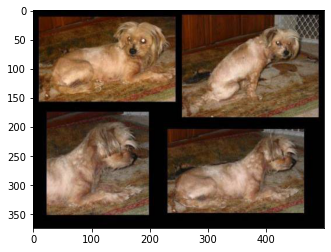

What is the class of this image?


KeyboardInterrupt: ignored

In [ ]:
import torchvision.transforms as transforms
np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)

train_dir = 'train/train'
test_dir = 'test/test'

device = torch.device("cuda")

train_set = IndexedDataset(train_dir, transform=transforms.Compose([transforms.Resize((224, 224)), 
                                                                transforms.ToTensor()]))
test_set = IndexedDataset(test_dir, transform=transforms.Compose([transforms.Resize((224, 224)), 
                                                                transforms.ToTensor()]), test=True) 
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

print('Train set size: ', len(train_set))
print('Test set size: ', len(test_set))

# Number of classes in the classification problem
n_classes = 2
mobilenet = torchvision.models.mobilenet_v3_small(pretrained=True)

for param in mobilenet.parameters():
    param.requires_grad = False
mobilenet.classifier._modules['3']  = nn.Sequential(
    nn.Linear(1024, 2, bias = True)
)
classifier = mobilenet.to(device) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9, dampening=0, weight_decay=0.0001)
        
# Label the initial subset
query_the_oracle(classifier, device, train_set, query_size=20, interactive=False, query_strategy='random', pool_size=0)
  
# How many times should the oracle be queried
num_queries = 3

batch_size = 32

# Pre-train on the initial subset
labeled_idx = np.where(train_set.unlabeled_mask == 0)[0]
labeled_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, 
                            sampler=SubsetRandomSampler(labeled_idx))
previous_test_acc = 0
current_test_acc = 1
while current_test_acc > previous_test_acc:
    previous_test_acc = current_test_acc
    train_loss = train(classifier, device, labeled_loader, optimizer, criterion)
    _, current_test_acc = test(classifier, device, test_loader, criterion)


test(classifier, device, test_loader, criterion, display=True)

for query in range(num_queries):
    
    # Query the oracle for more labels
    query_the_oracle(classifier, device, train_set, query_size=5, query_strategy='margin', interactive=True, pool_size=0)
    
    # Train the model on the data that has been labeled so far:
    labeled_idx = np.where(train_set.unlabeled_mask == 0)[0]
    labeled_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, 
                                sampler=SubsetRandomSampler(labeled_idx))
    previous_test_acc = 0
    current_test_acc = 1
    while current_test_acc > previous_test_acc:
        previous_test_acc = current_test_acc
        train_loss = train(classifier, device, labeled_loader, optimizer, criterion)
        _, current_test_acc = test(classifier, device, test_loader, criterion)


    # Test the model:
    test(classifier, device, test_loader, criterion, display=True)